# Drawing

This notebook is for making / demoing my drawing-based images. This currently includes:

- Chinese character based art
- Shape based art

How can I actually generate art? Steps are as follows:

- Generate PNG from code below (TODO - try SVG?)
- Visit [url](https://cam.openbuilds.com), pick the Acro A1 DrawBot with scribe extension
- Upload the PNG (drag and drop works)
- Select document (single checkbox) and select the following options:
    - "Pen Plotter: (no offset)" as type of cut
    - Endmill / Pen Diameter: 1mm (TODO - different width?)
- Click "Generate G-Code", and then you can click the eye icon to preview the G-Code (and copy it)

Still haven't figured out sizes - how can we resize without changing quality? Maybe only by making it an SVG? Or just get the GCode and scale it down via hacky regex Python?

Final update - I think I should just create GCode for this directly. How? Answer: greedily. Loop around a circle, and then without even raising the pen just move back around the circle to find the closest once that's next (greedily).

In [22]:
from IPython import get_ipython

ipython = get_ipython()
ipython.run_line_magic("load_ext", "autoreload")
ipython.run_line_magic("autoreload", "2")

import copy
import time

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotly.express as px
from IPython.display import HTML, SVG, Image, clear_output, display
from PIL import Image as PIL_Image

import drawing

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Chinese characters

Drawing shapes: 100%|██████████| 2000/2000 [00:19<00:00, 100.87it/s, filled_fraction=0.354, avg_target_img_value=0.323, best_avg_pixel_value=0.475]


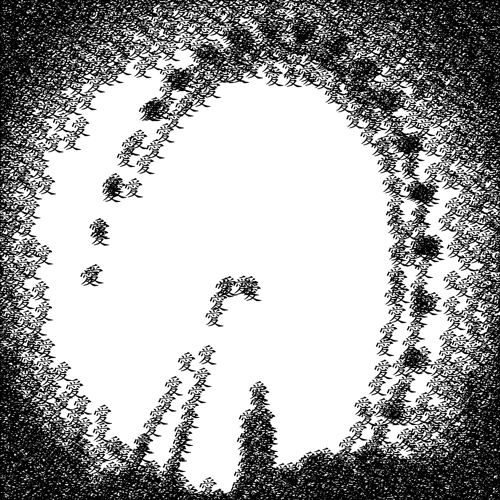

In [ ]:
params = DrawingParams(n_shapes=2000, char_size=40)

canvas = params.create_img()

# Okay finally got it looking good! Just had to keep decreasing the darkness
PIL_Image.fromarray(canvas).resize((500, 500))

Drawing shapes: 100%|██████████| 3200/3200 [00:08<00:00, 372.66it/s, filled_fraction=0.331, avg_target_img_value=0.068, best_avg_pixel_value=0.07]   


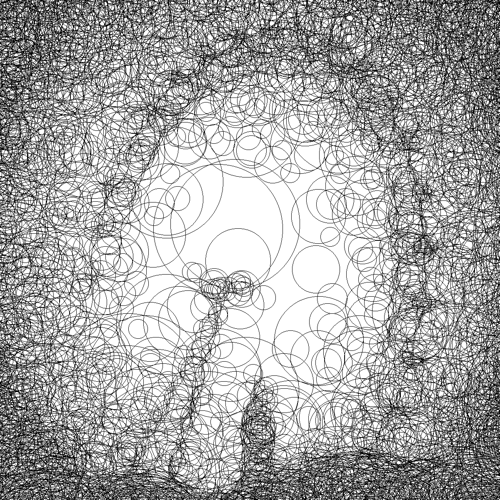

In [4]:
params = DrawingParams(
    mode="shapes",
    n_shapes=3200,
    x=500,
    output_x=1200,
    darkness=0.45,
    shape_sizes=(10, 80),
)

canvas = params.create_img()

PIL_Image.fromarray(canvas).resize((500, 500))

Drawing shapes: 100%|██████████| 3600/3600 [00:07<00:00, 458.91it/s, filled_fraction=0.289, avg_target_img_value=0.104, best_avg_pixel_value=0.169] 


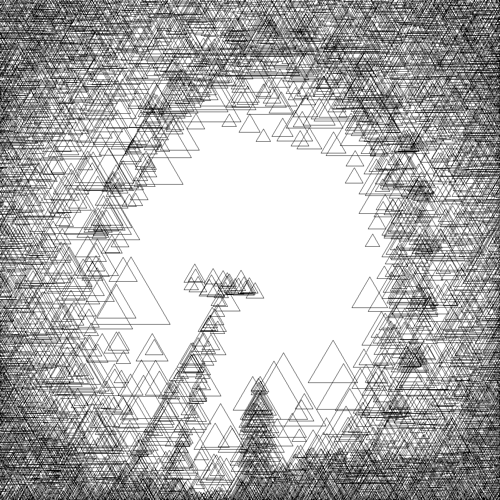

In [5]:
params = DrawingParams(
    mode="shapes",
    shape_type="tri",
    n_shapes=3600,
    x=500,
    output_x=1200,
    darkness=0.5,
    shape_sizes=(15, 100),
)

canvas = params.create_img()

PIL_Image.fromarray(canvas).resize((500, 500))

Drawing shapes: 100%|██████████| 4000/4000 [00:08<00:00, 463.31it/s, filled_fraction=0.289, avg_target_img_value=0.167, best_avg_pixel_value=0.299] 


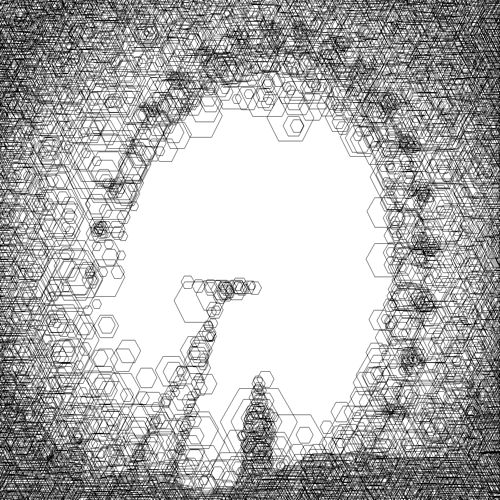

In [6]:
params = DrawingParams(
    mode="shapes",
    shape_type="hex",
    n_shapes=4000,
    x=500,
    output_x=1200,
    darkness=0.4,
    shape_sizes=(10, 100),
)

canvas = params.create_img()

PIL_Image.fromarray(canvas).resize((500, 500))

Drawing shapes: 100%|██████████| 3000/3000 [00:07<00:00, 400.85it/s, filled_fraction=0.298, avg_target_img_value=0.194, best_avg_pixel_value=0.324]


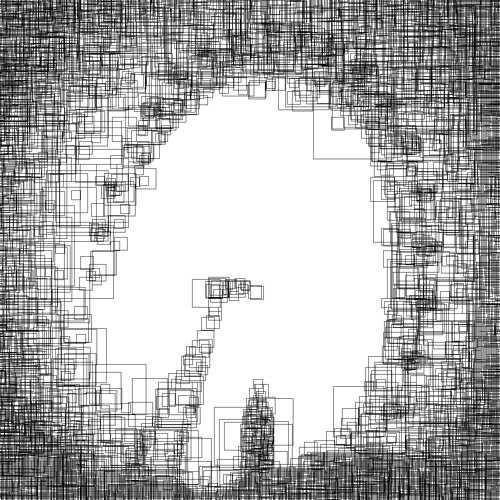

In [8]:
params = DrawingParams(
    mode="shapes",
    shape_type="rect",
    n_shapes=3000,
    x=500,
    output_x=1200,
    darkness=0.35,
    shape_sizes=(10, 100),
)

canvas = params.create_img()

PIL_Image.fromarray(canvas).resize((500, 500))

# Drawing (debugging / testing)

(2, 25) (2, 23)
-0.030735696693893626
(2, 17) (2, 3)
(2, 30) (2, 28)


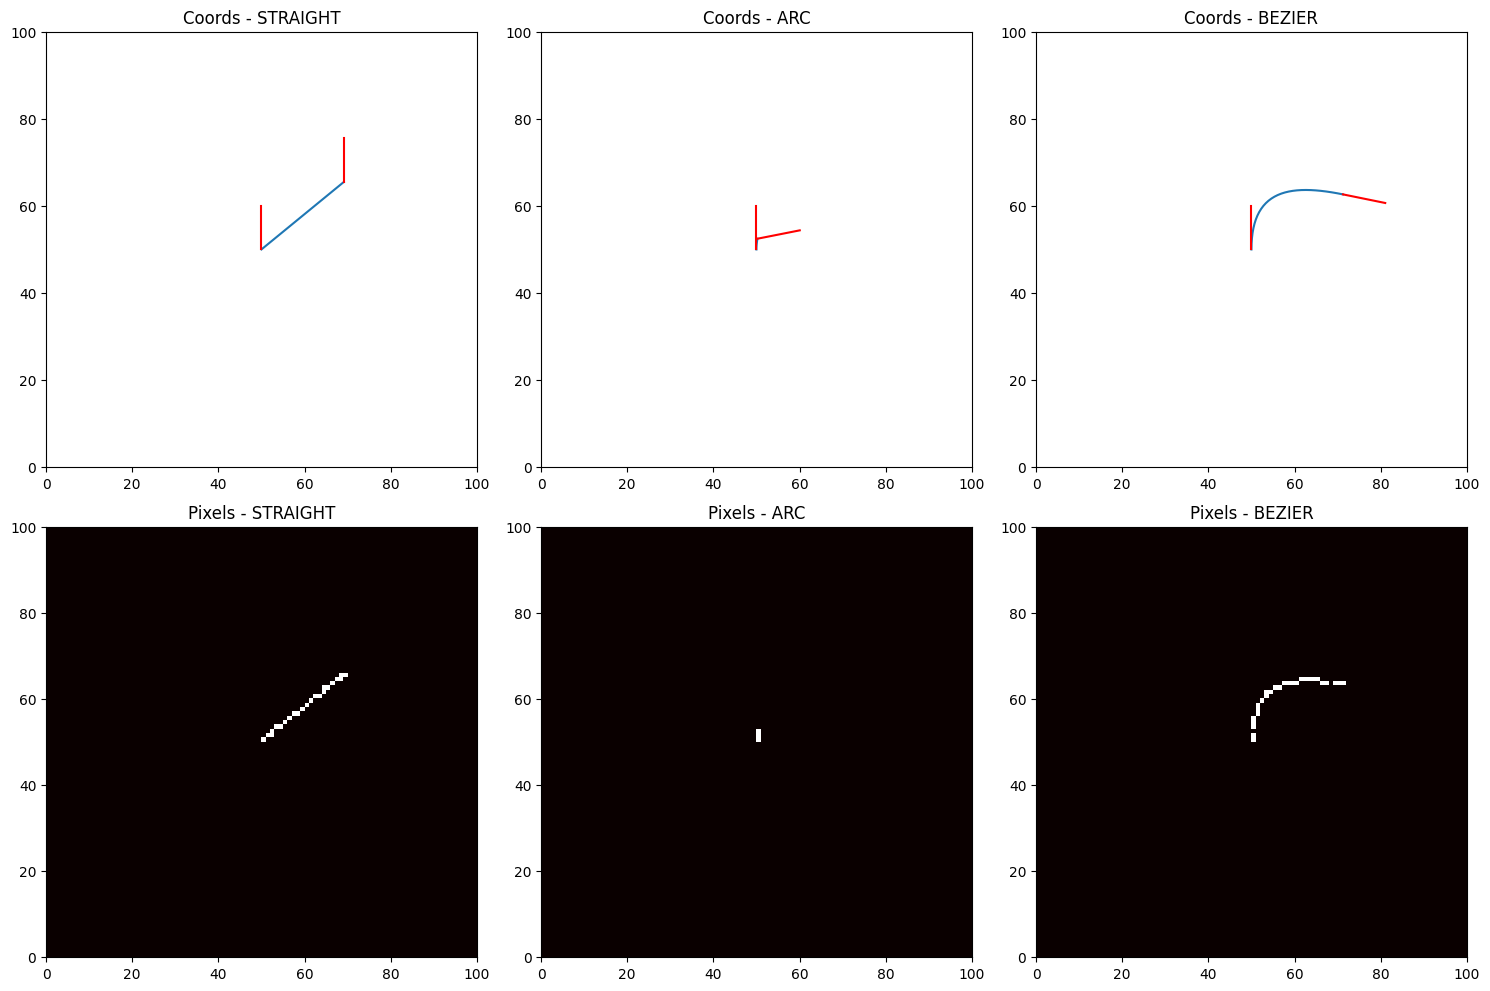

In [253]:
SHOW_TANGENTS = True
TWO_LINES = False

fig, axes = plt.subplots(2, 3, figsize=(15, 10))
canvas_length = 100.0
tangent_length = 0.1 * canvas_length

for i, line_type in enumerate(list(drawing.LineType)):
    # Create shape
    shape = drawing.Shape(
        line_type=line_type,
        size_range=(0.245, 0.255),
        endpoint_angle_range=(np.pi * 0.2, np.pi * 0.6),
        bezier_control_factor_range=(0.4, 0.6),
        bezier_end_angle_range=(-np.pi * 0.6, np.pi * 0.6),
    )

    # Get random parameters for shape & use them to get curve coordinates
    start_dir = np.array([1.0, 0.0])
    start_coords = np.array([50.0, 50.0])
    params = shape.get_random_params(start_coords, start_dir, canvas_length)
    coords1, pixels1, end_dir1 = shape.draw_curve(start_coords, start_dir, **params)
    end_coords1 = coords1[:, -1]

    if TWO_LINES:
        # Do this a second time, from the new position & angle
        params = shape.get_random_params(end_coords1, end_dir1, canvas_length)
        coords2, pixels2, end_dir2 = shape.draw_curve(end_coords1, end_dir1, **params)
        end_coords2 = coords2[:, -1]
        coords = np.concatenate([coords1, coords2], axis=1)
        pixels = np.concatenate([pixels1, pixels2], axis=1)
        all_dirs = [start_dir, end_dir1, end_dir2]
        all_coords = [start_coords, end_coords1, end_coords2]
    else:
        coords = coords1
        pixels = pixels1
        all_dirs = [start_dir, end_dir1]
        all_coords = [start_coords, end_coords1]

    # Plot coords
    ax_top = axes[0, i]
    ax_top.plot(coords[1], coords[0])
    if SHOW_TANGENTS:
        for dir, coords in zip(all_dirs, all_coords):
            start_end = coords + tangent_length * dir
            ax_top.plot([coords[1], start_end[1]], [coords[0], start_end[0]], "r-")
    ax_top.set_xlim(0, canvas_length)
    ax_top.set_ylim(0, canvas_length)
    ax_top.set_title(f"Coords - {line_type.name}")

    # Plot pixels
    ax_bottom = axes[1, i]
    grid = np.zeros((int(canvas_length), int(canvas_length)))
    for j in range(pixels.shape[1]):
        y, x = pixels[:, j]
        if 0 <= y < canvas_length and 0 <= x < canvas_length:
            grid[int(y), int(x)] = 1
    ax_bottom.imshow(grid, extent=[0, canvas_length, canvas_length, 0], cmap="hot")
    ax_bottom.set_xlim(0, canvas_length)
    ax_bottom.set_ylim(0, canvas_length)
    ax_bottom.set_title(f"Pixels - {line_type.name}")

plt.tight_layout()
plt.show()


# Drawing (actual pieces)

100%|██████████| 1050/1050 [01:21<00:00, 12.81it/s]


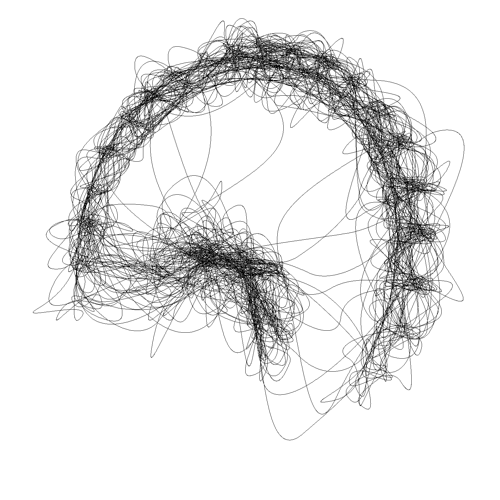

In [358]:
#
# ! What have I learned?
# Going down to min size of about 0.05 will give you closer accuracy to the exact image (cause you can draw tiny things)
# So you want it small but not too small (e.g. 0.08)
# Also increasing n_random does help: 250 is much better than 100 (I guess because more variables than thread art!)
# Btw, increasing `n_shapes` does make the digital version look better, but assuming it's too heavy for physical

mydraw = drawing.Drawing(
    image_path="images/london_eye_3a1.jpg",
    weight_image_path=None,
    x=800,
    output_x=1500,
    n_shapes=1050,
    n_random=250,
    darkness=0.23,
    negative_penalty=0.0,
    shape=drawing.Shape(
        line_type=drawing.LineType.BEZIER,
        size_range=(0.08, 0.5),
        endpoint_angle_range=(np.pi * 0.1, np.pi * 0.8),
        bezier_end_angle_range=(-np.pi * 0.8, np.pi * 0.8),
    ),
)

params_list, canvas, image, all_coords = mydraw.create_img()

display(canvas.resize((500, 500)))
canvas.save("outputs_drawing/london_eye.png")

# px.imshow(image, color_continuous_scale="RdBu", color_continuous_midpoint=0).update_layout(
#     width=500, height=400, margin=dict(l=10, r=10, t=10, b=10)
# )

np.save("outputs_drawing/london_eye_coords.npy", all_coords)


100%|██████████| 1800/1800 [01:31<00:00, 19.71it/s]


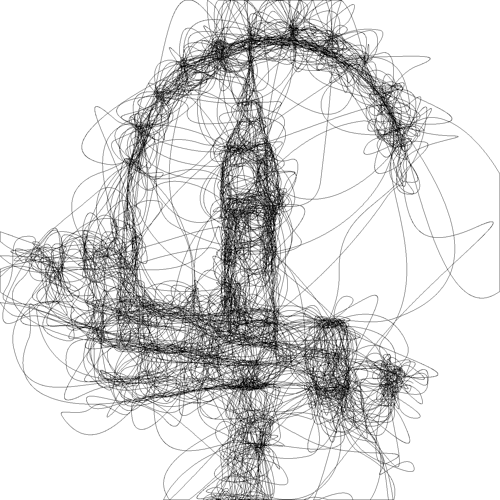

In [ ]:
mydraw = drawing.Drawing(
    image_path="images/big-ben-1e.jpg",
    weight_image_path=None,
    x=1024,
    output_x=1500,
    n_shapes=1700,
    n_random=150,
    darkness=0.26,
    negative_penalty=0.0,
    shape=drawing.Shape(
        line_type=drawing.LineType.BEZIER,
        size_range=(0.05, 0.5),
        endpoint_angle_range=(np.pi * 0.1, np.pi * 0.8),
        bezier_end_angle_range=(-np.pi * 0.8, np.pi * 0.8),
    ),
)

params_list, canvas, image, all_coords = mydraw.create_img()

display(canvas.resize((500, 500)))
canvas.save("outputs_drawing/london_big_ben_01.png")

# px.imshow(image, color_continuous_scale="RdBu", color_continuous_midpoint=0).update_layout(
#     width=500, height=400, margin=dict(l=10, r=10, t=10, b=10)
# )


100%|██████████| 1800/1800 [02:04<00:00, 14.51it/s]


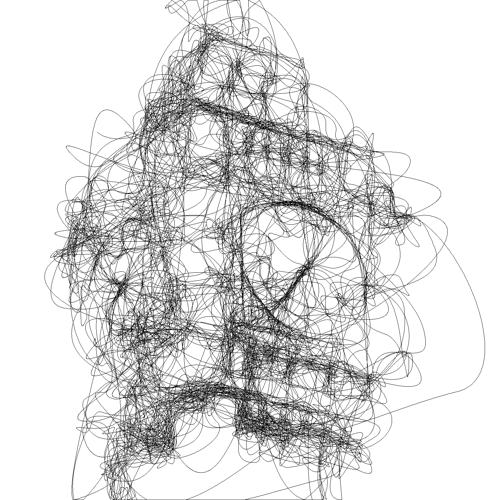

In [ ]:
mydraw = drawing.Drawing(
    image_path="images/big-ben-2d.jpg",
    # weight_image_path="images/big-ben-w-2c.jpg",
    weight_image_path=None,
    x=800,
    output_x=1500,
    n_shapes=1800,
    n_random=250,
    darkness=0.25,
    negative_penalty=0.0,
    shape=drawing.Shape(
        line_type=drawing.LineType.BEZIER,
        size_range=(0.05, 0.5),
        endpoint_angle_range=(np.pi * 0.1, np.pi * 0.8),
        bezier_end_angle_range=(-np.pi * 0.8, np.pi * 0.8),
    ),
)

params_list, canvas, image, all_coords = mydraw.create_img()

display(canvas.resize((500, 500)))
canvas.save("outputs_drawing/london_big_ben_02.png")

# px.imshow(image, color_continuous_scale="RdBu", color_continuous_midpoint=0).update_layout(
#     width=500, height=400, margin=dict(l=10, r=10, t=10, b=10)
# )
